### В этом ноутбуке тренируется модель RetinaNet на COCO-Text/Train и сохраняется на жесткий диск.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install unrar
!unrar x '/content/drive/MyDrive/task3.rar'
!unzip '/content/drive/MyDrive/train2014.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train20

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from task3.a4_course_cvdl_t3.coco_text import COCO_Text

In [2]:
anno_path = Path('/content/task3/a4_course_cvdl_t3/data/cocotext.v2.json')
images_path = Path("/content/train2014")

СOCO_Text взят из репозитория авторов датасета
https://github.com/andreasveit/coco-text/

In [3]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:03.912754
creating index...
index created!


#### Пример работы из репозитория coco-text
Взято из
https://github.com/andreasveit/coco-text/blob/master/coco_text_Demo.ipynb

In [4]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train,
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Text(0.5, 1.0, 'Изображение из датасета COCO')

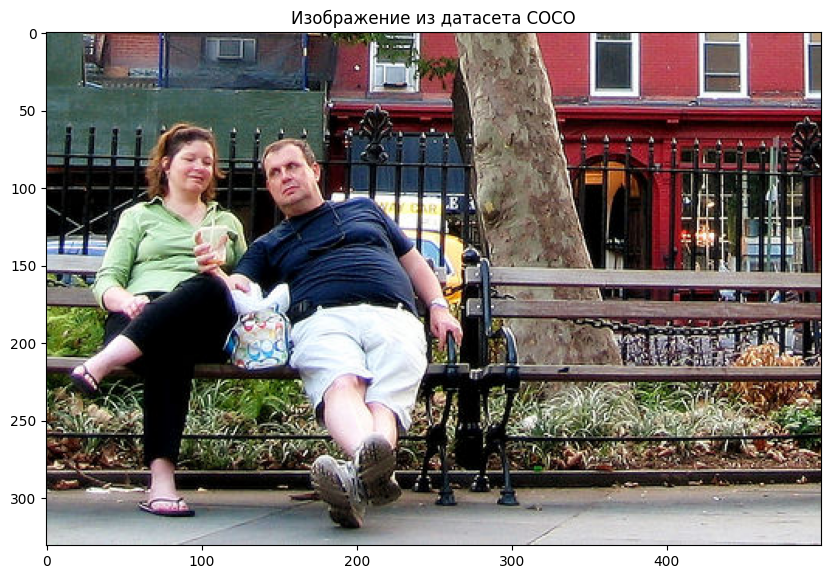

In [6]:
plt.imshow(plt.imread(images_path / img['file_name']))
plt.title("Изображение из датасета COCO")

Text(0.5, 1.0, 'Изображение с GT детекциями текста')

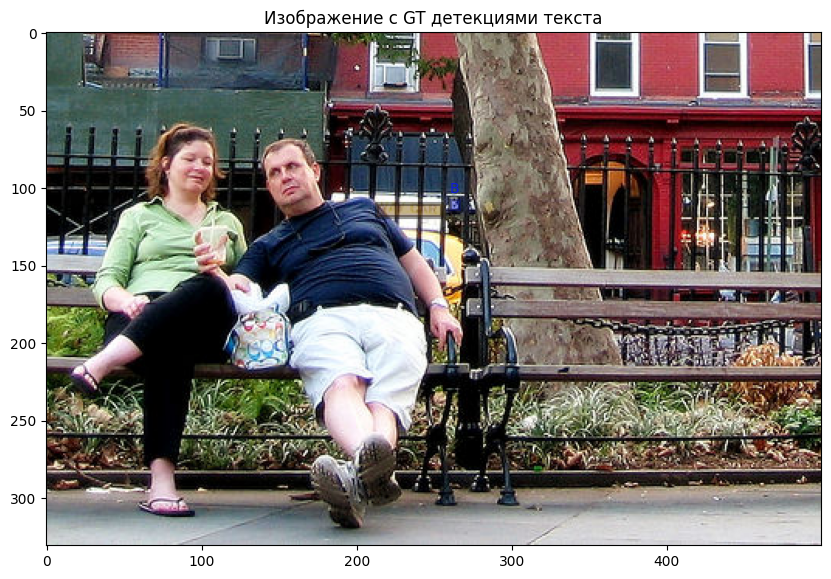

In [7]:
plt.imshow(plt.imread(images_path / img['file_name']))
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title("Изображение с GT детекциями текста")

### Подготовка датасетов

In [8]:
from task3.a4_course_cvdl_t3.coco_text import COCO_Text
from task3.a4_course_cvdl_t3 import coco_evaluation
from task3.a4_course_cvdl_t3.data import CocoTextDetection, CocoDetectionPrepareTransform

In [9]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [10]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [11]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=4, shuffle=True
)

In [12]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

### Подготовка модели
Используется RetinaNet из torchvision

In [13]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import mobilenet_v2, resnet50, efficientnet_b7

In [14]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

backbone = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

In [15]:
backbone = backbone.features
backbone.out_channels = 1408
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
model = RetinaNet(backbone,
                  num_classes=2,
                  anchor_generator=anchor_generator)

In [19]:
model = torch.load('/content/retina_coco_text.pth')

In [20]:
def prepare(images_tensor, center_boxes, device):
    """
    Функция подготовки изображения и боксов для torchvision-RetinaNet:
    - разбивает тензор T[B,C, H W] в список тензоров List[T[C, H, W]]
    - переводит тензоры на device
    - переводит боксы из формата [xc, yc, wx, hy] в [xmin, ymin, xmax, ymax]
    - устанавливает label класс как 1 для всех боксов
    - убирает боксы-"заглушки", заполненные -1
    """
    list_center_boxes = list(x for x in center_boxes)
    list_images = list(x.to(device) for x in images_tensor)
    list_boxes = []
    for cb in list_center_boxes:
        real_cboxes = cb[cb[:, -1] > 0]
        real_boxes = torch.ones_like(real_cboxes)
        real_boxes[:, 1] = real_cboxes[:, 0] - real_cboxes[:, 2] / 2
        real_boxes[:, 3] = real_cboxes[:, 0] + real_cboxes[:, 2] / 2
        real_boxes[:, 0] = real_cboxes[:, 1] - real_cboxes[:, 3] / 2
        real_boxes[:, 2] = real_cboxes[:, 1] + real_cboxes[:, 3] / 2
        boxes, labels, prob_ones = torch.split(real_boxes, [4, 1, 1], dim=1)
        list_boxes.append({"boxes": boxes.to(device), "labels": labels.long().to(device)})
    return list_images, list_boxes


In [21]:
gpu = torch.device('cuda:0')
opt = torch.optim.Adam(model.parameters())
sched = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)
model = model.to(gpu);

### Утилиты из torchvision:references/detection
Тренировка - копия туториала pytorch по Fine-Tune RetinaNet.

In [22]:
import datetime
import errno
import os
import time
from collections import defaultdict, deque

import torch
import torch.distributed as dist


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append("{}: {}".format(name, str(meter)))
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print("{} Total time: {} ({:.4f} s / it)".format(header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print("| distributed init (rank {}): {}".format(args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(
        backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [23]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = "Epoch: [{}]".format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        images, targets = prepare(images, targets, device)
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

### Запуск тренировки

In [25]:
logs = []
for i in range(1, 10):
    sched.step()
    print(opt.param_groups[0]['lr'])
    l = train_one_epoch(model, opt, trainloader, gpu, i + 1, 500)
    logs.append(l)

0.00025
Epoch: [2]  [   0/4760]  eta: 10:43:58  lr: 0.000250  loss: 1.2241 (1.2241)  classification: 0.4565 (0.4565)  bbox_regression: 0.7676 (0.7676)  time: 8.1173  data: 0.0988  max mem: 8992
Epoch: [2]  [ 500/4760]  eta: 1:03:20  lr: 0.000250  loss: 0.8517 (0.9476)  classification: 0.3932 (0.4220)  bbox_regression: 0.4503 (0.5256)  time: 0.8870  data: 0.0628  max mem: 10158
Epoch: [2]  [1000/4760]  eta: 0:55:51  lr: 0.000250  loss: 0.8884 (0.9282)  classification: 0.3755 (0.4054)  bbox_regression: 0.5431 (0.5228)  time: 0.9005  data: 0.0744  max mem: 10158
Epoch: [2]  [1500/4760]  eta: 0:48:24  lr: 0.000250  loss: 0.9907 (0.9070)  classification: 0.4139 (0.3947)  bbox_regression: 0.5938 (0.5123)  time: 0.8878  data: 0.0646  max mem: 10158
Epoch: [2]  [2000/4760]  eta: 0:41:01  lr: 0.000250  loss: 0.9212 (0.9069)  classification: 0.4080 (0.3940)  bbox_regression: 0.5034 (0.5129)  time: 0.8911  data: 0.0649  max mem: 10158
Epoch: [2]  [2500/4760]  eta: 0:33:35  lr: 0.000250  loss: 0.8

KeyboardInterrupt: ignored

In [ ]:
for i in range(11, 15):
    sched.step()
    print(opt.param_groups[0]['lr'])
    l = train_one_epoch(model, opt, trainloader, gpu, i + 1, 500)
    logs.append(l)

### Сохраняем модель на диск

In [26]:
torch.save(model.state_dict(), '/content/drive/MyDrive/retina_coco_text.pth')